### Microtubule Dynamics ABM 
### First visual verification notebook

In this notebook :
    
 - 1. Packages and Functions are loaded
 
 - 2. 3 Different Experiments are run
        - 1: Run of a single model with short output visualisation
        - 2: Parameter range scan over different GTP hydrolisis rates (:p_hyd)
        - 3: Ensemble run of 5 different GTP hydrolisis rates with a sample size of 30 models
    
 - 3. Example Interactive Explorer
    
  


## 1:  Packages and Functions :

Loading julia Packages and function scripts 

In [30]:
# load Packages:

using Agents
using StatsBase: counts
using Statistics: mean
using DataFrames
using Distributions
using DrWatson: @dict
using Serialization

# load Functions: 
include("init.jl")
include("agentstep.jl")
include("agent.jl")
include("analysis_funs.jl")
include("modelstep.jl")

model_step! (generic function with 1 method)

## 2: Experiments

### 2.1 Single Model

To start the row of simulation Experiments a single model is created.

Two vectors, `mdata` and `adata` are initalized to keep track of agent and model data.  

The model gets then progressed for 200 steps using the run! function and agent- and model data are saved. 


In [31]:
# Initialize Model

model=initialize(; Nstarts= 5,
        periodic= true,
        numagents = 2000,
        griddims=(100,100), 
        p_polym=0.8,
        p_hyd= 0.03,
        p_depolym_GTP=0,
        p_depolym_GDP=0.3) 

AgentBasedModel with 2005 agents of type tubulin
 space: GridSpace with size (100, 100), metric=chebyshev, periodic=true
 scheduler: randomly
 properties: tick, griddims, P_hyd, p_depolym_GDP, Nstarts, P_depolym_GTP, P_depolym_GDP, p_polym, p_hyd, p_depolym_GTP, numagents, P_polym

In [32]:
# Initialize vectors for model df and agent df :
mdata = [:p_hyd,mean_MT_size,sd_MT_size]
adata = [:pos, :polym, :GDP]

# Run the model:
 data = run!(model,agent_step!,model_step!,200; adata,  mdata)

# Save the data inside ./data
serialize("data/single_model1.jls", data)

# for convienence:
agentdata = data[1]; modeldata = data[2];

# show Agent Data:
agentdata[1:5,:]

,step,id,pos,polym,GDP
,Int64,Int64,Tuple…,Int64,Bool
1,0,1,"(50, 50)",1,1
2,0,2,"(26, 7)",2,1
3,0,3,"(12, 31)",3,1
4,0,4,"(2, 98)",4,1
5,0,5,"(90, 59)",5,1


In [7]:
# show Model Data:
modeldata[1:5,:]

,step,p_hyd,mean_MT_size,sd_MT_size
,Int64,Float64,Float64,Float64
1,0,0.03,1.0,0.0
2,1,0.03,1.2,0.447214
3,2,0.03,1.2,0.447214
4,3,0.03,1.2,0.447214
5,4,0.03,1.4,0.547723


#### Visual validation

To get a first impression of the model. 

The `abm_plot()` function from the InterativeDynamics package allows to plot the models gridspace at the current timestep. 

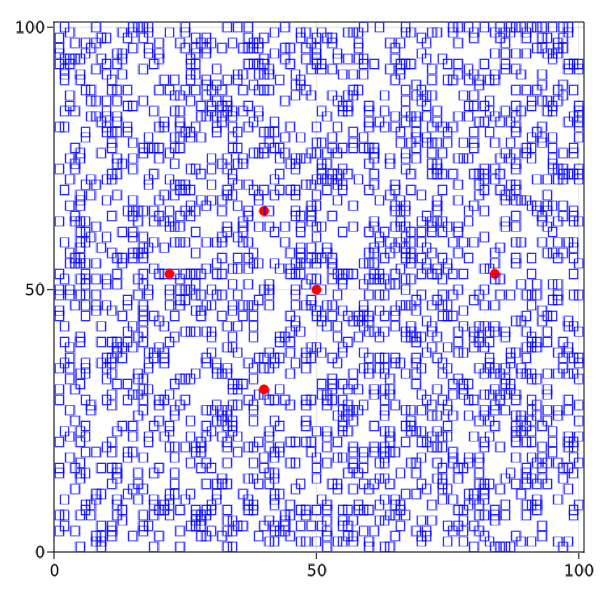

In [15]:
# Static Plot of last Timestep
# using abm_plot()
using InteractiveDynamics
using GLMakie
# aesthetics
groupcolor(a) = a.polym >= 1 ? :red : :blue 
groupmarker(a) = a.GDP == true ? :circle : :octagon
# figure
fig,stepper= abm_plot(model,ac=groupcolor, am=groupmarker)
fig

The Model is increased by one step:

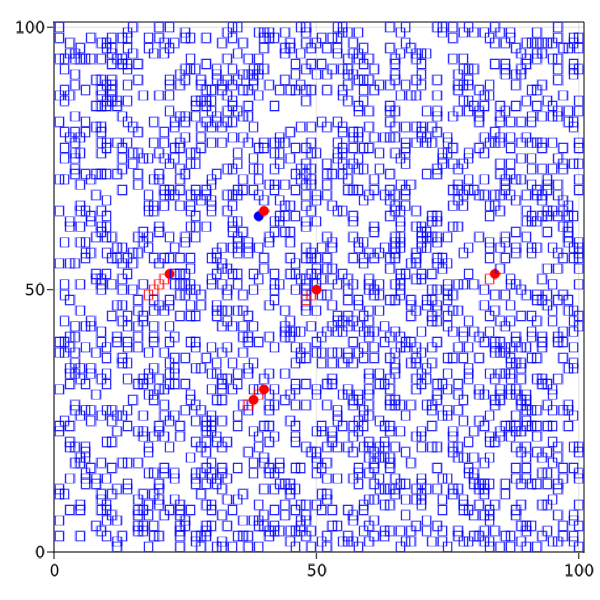

In [32]:
Agents.step!(stepper, model, agent_step!, model_step!, 1)
fig



More about animations using InteractiveDynamics in Point 3: `Example Interactive Explorer` .

For now we can look at the individual length of each MT over time using the `agentdata` using Plot @gif macro.


In [51]:
counts(agentdata[agentdata.step .== 3,:].polym)#[setdiff(1:end, 1), 1]

6-element Vector{Int64}:
 1988
    3
    5
    6
    2
    1

┌ Info: Saved animation to 
│   fn = /home/valentin/Schreibtisch/Microtubule/microtubule/tmp.gif
└ @ Plots /home/valentin/.julia/packages/Plots/vFFCj/src/animation.jl:114


Plots.AnimatedGif("/home/valentin/Schreibtisch/Microtubule/microtubule/tmp.gif")
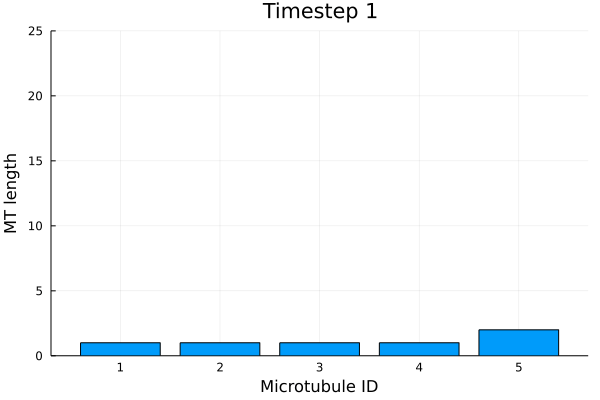

In [33]:
using Plots
@gif for i ∈ 1:200
    Plots.bar(counts(agentdata[agentdata.step .== i,:].polym)[setdiff(1:end, 1), 1],
    xlabel= "Microtubule ID", ylabel= "MT length", ylims= (0,25),title="Timestep $i",legend=:none)
end

In [ ]:
using Plots
@gif for i ∈ 1:200
    Plots.bar(counts(agentdata[agentdata.step .== i,:].polym)[setdiff(1:end, 1), 1],
    xlabel= "Microtubule ID", ylabel= "MT length", ylims= (0,25),title="Timestep $i",legend=:none)
end

### 2. 2: Parameter scan 
Parameter scan over a range of different GTP hydrolisis rates (:p_hyd)

This time only model data is tracked to save memory. 

In [45]:
#= Scanning  parameters =#

parameters=Dict(
            :griddims => (100,100),
            :periodic => true,
            :Nstarts => 3,
            :numagents => 1000, 
            :p_hyd => collect([0:0.05:0.6]...),      #### collect([0:0.05:0.6]...),              
            :p_polym=> 0.85 ,    
            :p_depolym_GTP => 0,
            :p_depolym_GDP => 0.1) 

# Model Data:
adata = [:pos, :polym, :GDP]
mdata=[mean_MT_size,sd_MT_size]; mlabels=["mean MT length", "sd"]
# Run Model 
paramdata = paramscan(parameters, initialize;  mdata,adata, agent_step!, model_step!, n=8000)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


(104325039×6 DataFrame
       Row │ step   id     pos        polym  GDP    p_hyd   
           │ Int64  Int64  Tuple…     Int64  Bool   Float64 
───────────┼────────────────────────────────────────────────
         1 │     0      1  (50, 50)       1   true      0.0
         2 │     0      2  (13, 65)       2   true      0.0
         3 │     0      3  (41, 15)       3   true      0.0
         4 │     0      4  (22, 100)      0  false      0.0
         5 │     0      5  (76, 79)       0  false      0.0
         6 │     0      6  (53, 75)       0  false      0.0
         7 │     0      7  (27, 60)       0  false      0.0
         8 │     0      8  (54, 63)       0  false      0.0
         9 │     0      9  (5, 17)        0  false      0.0
        10 │     0     10  (72, 80)       0  false      0.0
        11 │     0     11  (93, 3)        0  false      0.0
     ⋮     │   ⋮      ⋮        ⋮        ⋮      ⋮       ⋮
 104325030 │  8000    994  (12, 3)        0  false      0.6
 104325031 │  800

In [ ]:
#= save Results =#
serialize("data/paramdata.jls", paramdata)

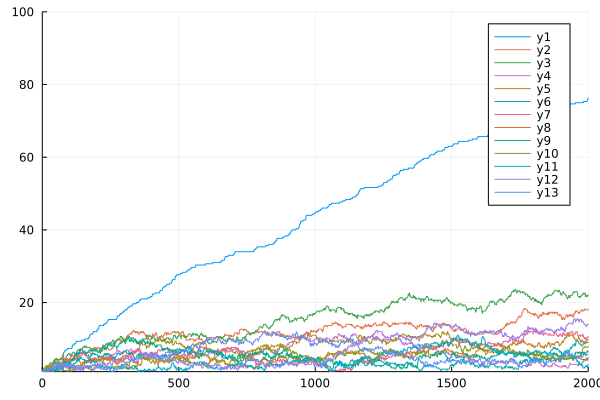

In [44]:
using Plots
p=Plots.plot()
for i in 1:length(levels(paramdata[2].p_hyd))
    Plots.plot!(ylim=(1,100),xlim=(0,2000),paramdata[2][paramdata[2].p_hyd .== levels(paramdata[2].p_hyd)[i],: ].mean_MT_size)
end
p

### 2. 3: Ensemble run:

The last experiment is a ensemble of several models with 5 different "treatments", defined by  
variable GTP => DGP hydralidsation-rates (0.015, 0.02, 0.025, 0.03, 0.035) with a samplesize of 30 for each treatment.

Each model has 5 starting points.


In [26]:
models = [initialize(;
        Nstarts= 5,
        periodic= true,
        numagents = 2000,
        griddims=(100,100), 
        p_polym=0.8,
        p_hyd= x,
        p_depolym_GTP=0,
        p_depolym_GDP=0.3)  
    for x in repeat(collect([0.015:0.005:0.035]...), 30)];

In [27]:
# Run ensemble of models for 12000 timesteps and collect data:

mdata=[mean_MT_size,sd_MT_size, (:p_hyd) ,(:p_depolym_GDP)]; mlabels=["mean MT length", "sd", "p_hyd","p_depolym_GDP"]


data_ens = ensemblerun!(models, agent_step!, model_step!, 12000; mdata,parallel=false)


(0×1 DataFrame, 1800150×6 DataFrame
     Row │ step   mean_MT_size  sd_MT_size  p_hyd    p_depolym_GDP  ensemble 
         │ Int64  Float64       Float64     Float64  Float64        Int64    
─────────┼───────────────────────────────────────────────────────────────────
       1 │     0           1.0    0.0         0.015            0.3         1
       2 │     1           1.0    0.0         0.015            0.3         1
       3 │     2           1.0    0.0         0.015            0.3         1
       4 │     3           1.0    0.0         0.015            0.3         1
       5 │     4           1.0    0.0         0.015            0.3         1
       6 │     5           1.2    0.447214    0.015            0.3         1
       7 │     6           1.4    0.547723    0.015            0.3         1
       8 │     7           1.4    0.547723    0.015            0.3         1
       9 │     8           1.6    0.547723    0.015            0.3         1
      10 │     9           1.6    0.5

In [28]:
# Save DataFrame

serialize("data/Ensemblef.jls", data_ens)

The analysis of the Ensemble is in the second notebook : analysis.ipynb

## 3. Interactive Visualistation:

The interactive visualisation uses 
GLMakie as graphic background and the Interactive Dynamics Package.
It usually takes a minute or two until the windiow opens, sice the programm has to be compiled and the vectorgraphic has to be rendered on the GPU.

Below is a example: 

(!) Initialize a _single model_ as described in 2.1 before running the Cell below. 


In [24]:
using GLMakie
using InteractiveDynamics

params = Dict(
    :p_hyd => 0:0.01:1,
    :p_polym => 0:0.01:1,
    :p_depolym_GTP => 0:0.01:1,
    :p_depolym_GDP =>0:0.01:1
)

GLMakie.activate!()
groupcolor(a) = a.polym >= 1 ? :red : :blue ; groupmarker(a) = a.GDP == true ? :circle : :octagon
mdata=[mean_MT_size,sd_MT_size]; mlabels=["mean MT length", "sd"]
adata = [(:GDP,sum)]; alabels = ["Hydrolized"]

fig, adf, mdf = abm_data_exploration(
    model, agent_step!, model_step!, params;
    ac=groupcolor, am=groupmarker, adata,alabels,mdata,mlabels
)

LoadError: InterruptException: